In [20]:
# Digits + Spectral Clustering (eigengap + silhouette to pick k) + t-SNE + ARI/NMI

In [22]:
# STEP 1: Imports

In [62]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from scipy.optimize import linear_sum_assignment
import warnings; warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
rng = np.random.RandomState(42)

In [26]:
# STEP 2: Load and scale

In [50]:
digits = load_digits()
X = digits.data
y = digits.target

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=40, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [30]:
# STEP 3: Eigengap heuristic on affinity

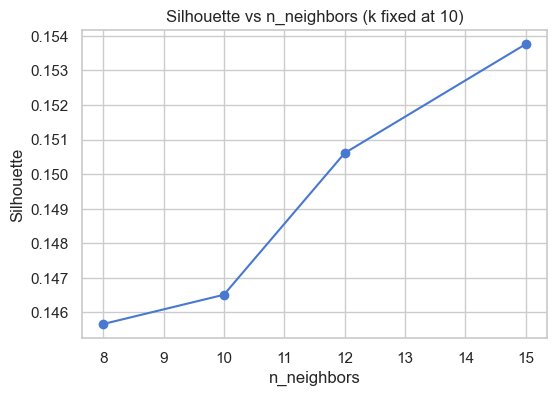

In [52]:
neighbor_grid = [8, 10, 12, 15]
sil_scores = []
for nn in neighbor_grid:
    sc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
                            n_neighbors=nn, assign_labels='kmeans',
                            random_state=42, n_init=10)
    labs = sc.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labs)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(neighbor_grid, sil_scores, marker="o")
plt.title("Silhouette vs n_neighbors (k fixed at 10)")
plt.xlabel("n_neighbors"); plt.ylabel("Silhouette"); plt.show()

n_neighbors_best = neighbor_grid[int(np.argmax(sil_scores))]

In [33]:
# STEP 4: Silhouette sweep around eigengap k

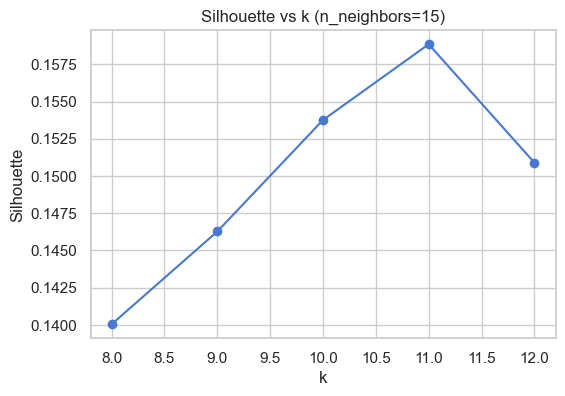

In [54]:
cand_k = list(range(8, 13))
sils_k = []
for k in cand_k:
    sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                            n_neighbors=n_neighbors_best, assign_labels='kmeans',
                            random_state=42, n_init=10)
    labs = sc.fit_predict(X_pca)
    sils_k.append(silhouette_score(X_pca, labs))

plt.figure(figsize=(6,4))
plt.plot(cand_k, sils_k, marker="o")
plt.title(f"Silhouette vs k (n_neighbors={n_neighbors_best})")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.show()

k_best = cand_k[int(np.argmax(sils_k))]

In [35]:
# STEP 5: Fit final spectral clustering

In [56]:
spec = SpectralClustering(n_clusters=k_best, affinity="nearest_neighbors",
                          n_neighbors=n_neighbors_best, assign_labels="kmeans",
                          random_state=42, n_init=20)
labels = spec.fit_predict(X_pca)

In [39]:
# STEP 6: t-SNE 2D visualization

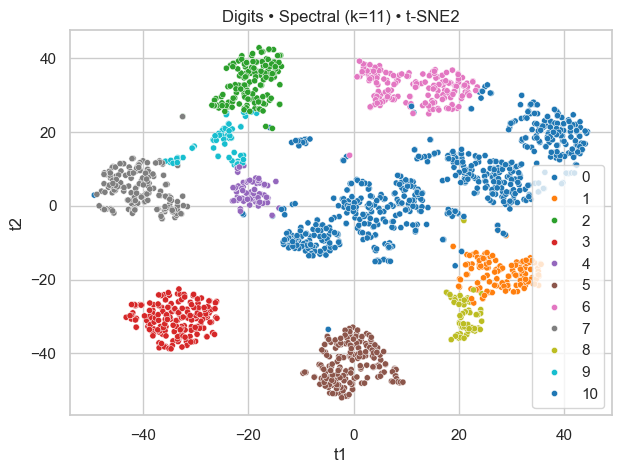

In [58]:
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto", perplexity=30)
Xt = tsne.fit_transform(Xs)
plt.figure(figsize=(7,5))
sns.scatterplot(x=Xt[:,0], y=Xt[:,1], hue=labels, palette="tab10", s=20, legend="full")
plt.title(f"Digits • Spectral (k={k_best}) • t-SNE2")
plt.xlabel("t1"); plt.ylabel("t2"); plt.show()

In [41]:
# STEP 7: Metrics

In [68]:
sil = silhouette_score(X_pca, labels)
ari = adjusted_rand_score(y, labels)
nmi = normalized_mutual_info_score(y, labels)

print({
    "k": int(k_best),
    "n_neighbors": int(n_neighbors_best),
    "silhouette": round(sil, 3),
    "ARI": round(ari, 3),
    "NMI": round(nmi, 3)
})

{'k': 11, 'n_neighbors': 15, 'silhouette': 0.159, 'ARI': 0.642, 'NMI': 0.788}
